In [1]:
# If pulled changes from github are not reflected, uncomment this code block. 
# Furthermore, restart all of your runtimes. 
# Colab sometimes seems to cache executed code from github, not using the latest pulled changes.
# %cd /content
# !rm -rf *

## Download our dataset from our Dropbox and our main dependencies
Make sure to add all newly created data to the `combined_jsons` folder in our shared dropbox. The data will be directly curled from it.

In [2]:
import os

REPO = "confusion_detection"
%cd /content

if not os.path.exists(f"/content/{REPO}"):
  !rm -rf *
  !git clone https://github.com/leomorpho/confusion_detection.git
  %cd confusion_detection
else:
  %cd /content
  %cd confusion_detection
  !git fetch --all
  !git reset --hard origin/master

assert(os.getcwd() == "/content/confusion_detection")

/content
Cloning into 'confusion_detection'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 7444 (delta 9), reused 14 (delta 4), pack-reused 7421
Receiving objects: 100% (7444/7444), 155.41 MiB | 33.28 MiB/s, done.
Resolving deltas: 100% (711/711), done.
/content/confusion_detection


In [3]:
# Implement a flag to allow/disallow printing of more details
# Set to true if you want to see more details
DEBUG_OUTPUT = False

## Preprocess

In [4]:
from glob import glob
from typing import *
import json

DATA_DIR = "data/combined_jsons"
dataset_paths = glob(f"{DATA_DIR}/*")
print("dataset_paths is: ", dataset_paths)
print("dataset_paths count is: ", len(dataset_paths))

# We need all frames to have the same number of features for the models
length_75 = []
length_55 = []
length_75_count = 0
length_55_count = 0
length_unknown = []
length_unknown_count = 0
indeces_to_pop = []
# Create single list object from all the JSONs to run through preprocessing
raw_sequences: List[List[List[float]]] = []
for path in dataset_paths:
  with open(path, "r") as f:
    sequences = json.loads(f.read())
    for seq in sequences:
      if len(seq) > 55:
        length_75_count += 1
        length_75.append([path, seq])
      elif len(seq) == 55:
        length_55_count += 1
        length_55.append([path, seq])
      else:
        length_unknown_count += 1
        length_unknown.append([path, seq])
    raw_sequences.append(sequences)

# Remove all frames that do not have 55 features (Confusion Score + 54 OpenPose points)
for i in range(len(raw_sequences)):
  for j in range(len(raw_sequences[i])):
    if len(raw_sequences[i][len(raw_sequences[i])-j-1]) != 55:
      indeces_to_pop.append([i, len(raw_sequences[i])-j-1])
      if DEBUG_OUTPUT:
        print("not 55: ", len(raw_sequences[i][len(raw_sequences[i])-j-1]))


print("Number of indeces to pop: ", len(indeces_to_pop))
for (i, j) in sorted(indeces_to_pop, reverse=True):
  raw_sequences[i].pop(j)


print("length_75_count is: ", length_75_count)
print("length_55_count is: ", length_55_count)
print("length_unknown_count is: ", length_unknown_count)
print("length of raw_sequences is: ", len(raw_sequences))

if DEBUG_OUTPUT:
  print("length_75 is: ", len(length_75))
  print("length_55 is: ", len(length_55))
  print("length_unknown is: ", len(length_unknown))

  for (path, seq) in length_75:
    print("length_75 is: ", path)

  for (path, seq) in length_unknown:
    print("length_unknown is: ", path)
    print("length is: ", len(seq))


dataset_paths is:  ['data/combined_jsons/2019-10-15-14-15-19bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-16-14-12-40bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-15-14-22-48bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-15-14-15-19bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-24-14-32-29bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-15-14-12-10bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-15-05-09bag_img_raw_03_combined.json', 'data/combined_jsons/2019-10-10-14-24-28bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-14-25-07bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-15-05-09bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-24-15-21-13bag_img_raw_03_combined.json', 'data/combined_jsons/2019-11-05-14-14-31bag_img_raw_03_combined.json', 'data/combined_jsons/2019-12-05-14-20-24bag_img_raw_04_combined.json', 'data/combined_jsons/2019-12-05-15-15-46bag_img_raw_01_co

In [5]:
counts = [0,0,0,0]
total_count = 0

for sequence in raw_sequences:
  for frame in sequence:
    total_count += 1
    if int(frame[0]) == 0:
      counts[0] += 1
    elif int(frame[0]) == 1:
      counts[1] += 1
    elif int(frame[0]) == 2:
      counts[2] += 1
    elif int(frame[0]) == 3:
      counts[3] += 1

print("counts are: ", counts)
print(f"total_count: {total_count}")
print(f"total_count - number_of_zeroes: {total_count - counts[0]}")

counts are:  [3955, 16081, 11363, 11445]
total_count: 42844
total_count - number_of_zeroes: 38889


Get centroid for every frame. If the centroid differs widely between 2 frames, it may indicate that different people were picked up by OpenPose.
Centroid code taken from [here](https://stackoverflow.com/questions/23020659/fastest-way-to-calculate-the-centroid-of-a-set-of-coordinate-tuples-in-python-wi).

Format of OpenPose output can be found [here](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md). A frame is represented by `x1,y1,c1,x2,y2,c2,...`

If a dropped frame is between 2 valid sequences, consider stitching them back together.
* Drop frames which have **no subject** in them.
* Drop frames which have **wrong** subject in them.
* Give unit variance and zero mean to all points.

In [6]:
from jupyter_tools.preprocessing import stitch_frames, normalize

print(f"Number of raw sequences:        {len(raw_sequences)}")
parsed_sequences = stitch_frames(raw_sequences, min_dist=50, min_sequence_len=40, max_dropped_frames=4)
print(f"Number of stitched sequences:   {len(parsed_sequences)}")
preprocessed_sequences = normalize(parsed_sequences)
print(f"Number of preprocessed sequences: {len(preprocessed_sequences)}")

Number of raw sequences:        146
Number of stitched sequences:   201
Number of preprocessed sequences: 201


In [7]:
# Get some info on preprocessed_sequences
counts = [0,0,0,0]
total_count = 0

for sequence in preprocessed_sequences:
  for frame in sequence:
    total_count += 1
    if int(frame[0]) == 0:
      counts[0] += 1
    elif int(frame[0]) == 1:
      counts[1] += 1
    elif int(frame[0]) == 2:
      counts[2] += 1
    elif int(frame[0]) == 3:
      counts[3] += 1

print("counts are: ", counts)
print(f"total_count: {total_count}")
print(f"total_count - number_of_zeroes: {total_count - counts[0]}")

counts are:  [0, 9461, 6817, 8135]
total_count: 24413
total_count - number_of_zeroes: 24413


In [8]:
import pandas as pd

# Visualize statistics regarding preprocessed_sequences
sequences_len = []
for sequence in preprocessed_sequences:
  sequences_len.append(len(sequence))

a = pd.DataFrame(sequences_len)
a.describe()

,0
count,201.000000
mean,121.457711
std,102.400388
min,40.000000
25%,54.000000
50%,84.000000
75%,143.000000
max,683.000000


## Model
Create 3 models
* simple Sequential NN
* simple LSTM
* complex LSTM

First, we need to extract the X and Y values from our dataset in order to use them on the model.
Our Y will be our confusion annotations, and our X will be all the openPose coordinates.

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

nn_input_data = np.asarray(preprocessed_sequences)

nn_data = []
nn_target = []
# Split the data into training and target arrays
for row in range(len(nn_input_data)):
    for frame in range(len(nn_input_data[row])):
        target = nn_input_data[row][frame][0]
        data = []
        for datum in nn_input_data[row][frame][1:]:
          data.append(datum)
        nn_data.append(data)
        nn_target.append(target)
print("Completed splitting data into training and target arrays")

Completed splitting data into training and target arrays


In [10]:
## Because we have stripped away all 0s from the Confusion Score,
## The target set must now be reduced from 1-3 to 0-2, to play nicely with the models
nn_target_reduced = []
target_counts = [0,0,0]
print("Previous Values: ", nn_target[0:10])
for i in range(len(nn_target)):
  if nn_target[i] == 3:
    nn_target_reduced.append(2)
    target_counts[2] += 1
  elif nn_target[i] == 2:
    nn_target_reduced.append(1)
    target_counts[1] += 1
  elif nn_target[i] == 1:
    nn_target_reduced.append(0)
    target_counts[0] += 1
  else:
    print("found invalid value: ", nn_target[i])

print(" Current Values: ", nn_target_reduced[0:10])

print("Target Counts for Not Confused, Maybe Confused, and Confused: ", target_counts)

Previous Values:  [3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
 Current Values:  [2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
Target Counts for Not Confused, Maybe Confused, and Confused:  [9461, 6817, 8135]


In [11]:
nn_data_np = np.asarray(nn_data)
nn_target_np = np.asarray(nn_target_reduced)
nn_data_pd = pd.DataFrame(nn_data)
nn_target_pd = pd.DataFrame(nn_target_reduced)

print("nn_data_pd shape is: ", nn_data_pd.shape)
print("nn_data_pd type is: ",nn_data_np.dtype)

if DEBUG_OUTPUT:
  print("Output of the first frame data: ", nn_data_np[0])

nn_data_pd shape is:  (24413, 54)
nn_data_pd type is:  float64


### Statistics for the OpenPose Coordinate Data
There are 54 features provided from OpenPose.
Each feature represents the locations of the subject's body part in space.
These values have been normalized in preprocessing.

In [12]:
nn_data_pd.describe().T

,count,mean,std,min,25%,50%,75%,max
0,24413.0,0.417873,1.021192,-1.257885,-0.823395,1.017858,1.281385,1.838729
1,24413.0,-0.297094,0.445021,-1.109977,-0.470610,-0.283905,-0.029529,1.070167
2,24413.0,-1.053940,0.129619,-1.398062,-1.139929,-1.057964,-0.981405,-0.243291
3,24413.0,1.083413,0.428562,-0.573959,0.981120,1.230301,1.352876,2.962752
4,24413.0,0.035283,0.346639,-0.610912,-0.236067,-0.058506,0.261476,2.926365
5,24413.0,-1.052703,0.130106,-1.395453,-1.139525,-1.056334,-0.980206,-0.243291
6,24413.0,1.072625,0.452394,-0.803860,0.959321,1.205793,1.352565,3.663435
7,24413.0,0.034763,0.344282,-0.712949,-0.232283,-0.054772,0.257128,1.503020
8,24413.0,-1.052886,0.130000,-1.395578,-1.139630,-1.056476,-0.980325,-0.243291
9,24413.0,1.051182,0.497909,-1.113973,0.933063,1.186099,1.356213,2.189843


In [13]:
nn_target_pd.describe()

,0
count,24413.000000
mean,0.945685
std,0.847256
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Next, apply the data to the Models

1.   Simple Sequential NN
2.   Simple LSTM
3.   Complex LSTM



In [14]:
# Split the data into training and test sets
twenty_percent_split = int(np.floor(len(nn_data_np) * 0.8))
x_train_split = nn_data_np[0:twenty_percent_split]
x_test_split = nn_data_np[twenty_percent_split:]
y_train_split = nn_target_np[0:twenty_percent_split]
y_test_split = nn_target_np[twenty_percent_split:]

# Split the training set into train & validation
twenty_percent_validate_split = int(np.floor(len(x_train_split) * 0.8))
x_train = x_train_split[0:twenty_percent_validate_split]
x_validate = x_train_split[twenty_percent_validate_split:]
y_train = y_train_split[0:twenty_percent_validate_split]
y_validate =  y_train_split[twenty_percent_validate_split:]

print("x_train length is: ", len(x_train))
print("x_validate length is: ", len(x_validate))
print("x_test_split length is: ", len(x_test_split))

x_train length is:  15624
x_validate length is:  3906
x_test_split length is:  4883


Simpe Sequential NN

In [15]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Build the model, compile it, and run the training
snn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

snn_model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

snn_history = snn_model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2, validation_data=(x_validate, y_validate))
print("Training Completed")

Epoch 1/10
15624/15624 - 16s - loss: 1.0855 - accuracy: 0.3927 - val_loss: 1.0937 - val_accuracy: 0.3479
Epoch 2/10
15624/15624 - 16s - loss: 1.0761 - accuracy: 0.4018 - val_loss: 1.0939 - val_accuracy: 0.3671
Epoch 3/10
15624/15624 - 16s - loss: 1.0714 - accuracy: 0.4091 - val_loss: 1.0995 - val_accuracy: 0.3738
Epoch 4/10
15624/15624 - 16s - loss: 1.0666 - accuracy: 0.4149 - val_loss: 1.1100 - val_accuracy: 0.3710
Epoch 5/10
15624/15624 - 16s - loss: 1.0610 - accuracy: 0.4241 - val_loss: 1.1319 - val_accuracy: 0.3917
Epoch 6/10
15624/15624 - 15s - loss: 1.0578 - accuracy: 0.4238 - val_loss: 1.1132 - val_accuracy: 0.3628
Epoch 7/10
15624/15624 - 17s - loss: 1.0550 - accuracy: 0.4293 - val_loss: 1.1632 - val_accuracy: 0.3651
Epoch 8/10
15624/15624 - 16s - loss: 1.0518 - accuracy: 0.4336 - val_loss: 1.1734 - val_accuracy: 0.3694
Epoch 9/10
15624/15624 - 15s - loss: 1.0495 - accuracy: 0.4345 - val_loss: 1.1216 - val_accuracy: 0.3774
Epoch 10/10
15624/15624 - 18s - loss: 1.0472 - accuracy

In [16]:
# Get the target predictions for the test set on the trained model
predict_snn = snn_model.predict(x_test_split)

In [17]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_snn)):
  rounded = []
  for j in range(len(predict_snn[i])):
    rounded.append(round(predict_snn[i][j], 3))
  
  # check if the prediction was correct or not
  if predict_snn[i][y_test_split[i]] == max(predict_snn[i]):
    correctness[0][0] += 1
    correctness[0][1] += predict_snn[i][y_test_split[i]]
    target_correctness[y_test_split[i]][0] += 1
  else:
    correctness[1][0] += 1
    correctness[1][1] += predict_snn[i][y_test_split[i]]
    correctness[1][2] += max(predict_snn[i])
    target_correctness[y_test_split[i]][1] += 1
  rounded_predict.append(rounded)

if DEBUG_OUTPUT:
  # compare actual score vs prediction for a subset of the array
  for i in range(1,80):
    print(y_test_split[i], rounded_predict[i][y_test_split[i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)

Results:  [[1599, 0.4368302429781026], [3284, 0.2941925811401444, 0.421576911554049]]
Percentage Correct:  32.74626254351833
Predictions per target value:  [[474, 1537, 0.23570363003480854], [53, 1393, 0.03665283540802213], [1072, 354, 0.7517531556802244]]


In [18]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for k in range(len(rounded_predict[i])):
    if predict_snn[i][k] > prediction_max[k]:
      prediction_max[k] = predict_snn[i][k]
    if predict_snn[i][k] < prediction_min[k]:
      prediction_min[k] = predict_snn[i][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.9347983, 0.9998516, 0.9416299]
min probability predictions:  [0.00014840427, 0.010750251, 2.3145747e-08]


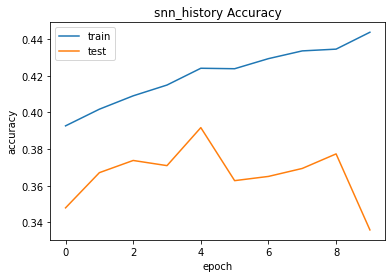

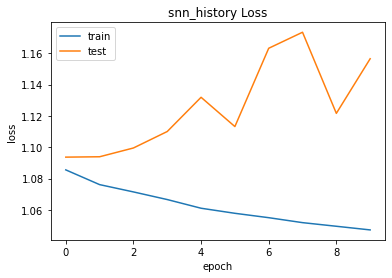

       loss  accuracy  val_loss  val_accuracy
0  1.085521  0.392665  1.093660      0.347926
1  1.076105  0.401754  1.093900      0.367128
2  1.071445  0.409050  1.099505      0.373784
3  1.066568  0.414939  1.110025      0.370968
4  1.061024  0.424091  1.131882      0.391705
5  1.057789  0.423835  1.113187      0.362775
6  1.054989  0.429339  1.163188      0.365079
7  1.051824  0.433564  1.173426      0.369432
8  1.049507  0.434524  1.121618      0.377368
9  1.047176  0.443740  1.156505      0.335894


In [19]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize snn_history for accuracy
plt.plot(snn_history.history['accuracy'])
plt.plot(snn_history.history['val_accuracy'])
plt.title('snn_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize snn_history for loss
plt.plot(snn_history.history['loss'])
plt.plot(snn_history.history['val_loss'])
plt.title('snn_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(snn_history.history)
print(history_pd)

**Create a 3D array with a constant step-size for the LSTM**

In [20]:
import numpy as np

number_of_features = 54
window_size = 10
window_size_array_x = []
window_size_array_y = []
index = 0
while index <= len(nn_data):
  if index+window_size > len(nn_data):
    break
  data_x = []
  data_y = []
  for i in range(index, index+window_size, 1):
    data_x.append(tf.convert_to_tensor(nn_data[i][:number_of_features]))
    data_y.append(tf.convert_to_tensor(nn_target_reduced[i]))
  window_size_array_x.append(data_x)
  window_size_array_y.append(data_y)
  index += window_size

print("Completed reshaping the array based on Window Size")

Completed reshaping the array based on Window Size


### Train Model

In [21]:
## THIS CELL TAKES QUITE A WHILE TO PROCESS (just a heads up)

# Split the data into training and test sets
twenty_percent_split = int(np.floor(len(window_size_array_x) * 0.8))
x_train_split = window_size_array_x[0:twenty_percent_split]
x_test_split = window_size_array_x[twenty_percent_split:]
y_train_split = window_size_array_y[0:twenty_percent_split]
y_test_split = window_size_array_y[twenty_percent_split:]

# Split the training set into train & validation
twenty_percent_validate_split = int(np.floor(len(x_train_split) * 0.8))
x_train_temp = x_train_split[0:twenty_percent_validate_split]
x_validate = x_train_split[twenty_percent_validate_split:]
y_train_temp = y_train_split[0:twenty_percent_validate_split]
y_validate =  y_train_split[twenty_percent_validate_split:]
print("arrays have been split")

# Convert the arrays into npArrays
x_train_lstm = np.asarray(x_train_temp)
print("x_train_temp has been converted to np")
x_validate_lstm = np.asarray(x_validate)
print("x_validate has been converted to np")
x_test_lstm = np.asarray(x_test_split)
print("x_test1 has been converted to np")
y_train_lstm = np.asarray(y_train_temp)
print("y_train_temp has been converted to np")
y_validate_lstm = np.asarray(y_validate)
print("y_validate has been converted to np")
y_test_lstm = np.asarray(y_test_split)
print("y_test1 has been converted to np")

print("x_train_lstm shape is: ", x_train_lstm.shape)
print("x_validate_lstm shape is: ", x_validate_lstm.shape)

arrays have been split
x_train_temp has been converted to np
x_validate has been converted to np
x_test1 has been converted to np
y_train_temp has been converted to np
y_validate has been converted to np
y_test1 has been converted to np
x_train_lstm shape is:  (1561, 10, 54)
x_validate_lstm shape is:  (391, 10, 54)


Simple LSTM

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# We will use EarlyStopping to limit required amount of epochs with: ,callbacks = [early_stopping]
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')

# As a general rule-of-thumb, the number of hidden layers should roughly equal Ns / (alpha*(Ni+No))
hidden_nodes = int(len(x_train_lstm) / (6 * (54+3)))
print("number of hidden nodes: ", hidden_nodes)

# Build the simple LSTM, comprised of a single LSTM layer
simple_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model using Adam optimization, as it is considered the best for LSTMs
simple_lstm_model.compile(optimizer='adam',
                               loss="sparse_categorical_crossentropy",
                            metrics=['accuracy'])

simple_lstm_history = simple_lstm_model.fit(x_train_lstm, y_train_lstm, 
                                            batch_size=window_size, epochs=10, verbose=2,
                                            callbacks=[early_stopping],
                                            validation_data=(x_validate_lstm, y_validate_lstm))

print("Training Completed")

number of hidden nodes:  4
Epoch 1/10
157/157 - 1s - loss: 1.0911 - accuracy: 0.3717 - val_loss: 1.0840 - val_accuracy: 0.4077
Epoch 2/10
157/157 - 1s - loss: 1.0849 - accuracy: 0.3945 - val_loss: 1.0789 - val_accuracy: 0.4315
Epoch 3/10
157/157 - 1s - loss: 1.0815 - accuracy: 0.4076 - val_loss: 1.0838 - val_accuracy: 0.3887
Epoch 4/10
157/157 - 1s - loss: 1.0783 - accuracy: 0.4088 - val_loss: 1.0816 - val_accuracy: 0.4210
Epoch 5/10
157/157 - 1s - loss: 1.0776 - accuracy: 0.4098 - val_loss: 1.0910 - val_accuracy: 0.3363
Epoch 6/10
157/157 - 1s - loss: 1.0746 - accuracy: 0.4159 - val_loss: 1.0893 - val_accuracy: 0.3609
Training Completed


Complex LSTM

In [23]:
# Construct the complex LSTM using 3 LSTM layers 
# With 20% random node dropouts between each layer to prevent overfitting
complex_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model using Adam optimization, as it is considered the best for LSTMs
complex_lstm_model.compile(optimizer='adam',
                                loss="sparse_categorical_crossentropy",
                             metrics=['accuracy'])

complex_lstm_history = complex_lstm_model.fit(x_train_lstm, y_train_lstm, 
                                              batch_size=window_size, epochs=10, verbose=2,
                                              callbacks=[early_stopping],
                                              validation_data=(x_validate_lstm, y_validate_lstm))

print("Training Completed")

Epoch 1/10
157/157 - 3s - loss: 1.0927 - accuracy: 0.3596 - val_loss: 1.0872 - val_accuracy: 0.4028
Epoch 2/10
157/157 - 2s - loss: 1.0899 - accuracy: 0.3685 - val_loss: 1.0853 - val_accuracy: 0.3969
Epoch 3/10
157/157 - 2s - loss: 1.0885 - accuracy: 0.3817 - val_loss: 1.0817 - val_accuracy: 0.4233
Epoch 4/10
157/157 - 2s - loss: 1.0874 - accuracy: 0.3810 - val_loss: 1.0838 - val_accuracy: 0.4159
Epoch 5/10
157/157 - 2s - loss: 1.0858 - accuracy: 0.3849 - val_loss: 1.0843 - val_accuracy: 0.4138
Epoch 6/10
157/157 - 2s - loss: 1.0844 - accuracy: 0.3908 - val_loss: 1.0837 - val_accuracy: 0.4105
Epoch 7/10
157/157 - 2s - loss: 1.0826 - accuracy: 0.3898 - val_loss: 1.0808 - val_accuracy: 0.4253
Epoch 8/10
157/157 - 2s - loss: 1.0815 - accuracy: 0.3972 - val_loss: 1.0839 - val_accuracy: 0.4133
Epoch 9/10
157/157 - 2s - loss: 1.0815 - accuracy: 0.3984 - val_loss: 1.0827 - val_accuracy: 0.4038
Epoch 10/10
157/157 - 2s - loss: 1.0819 - accuracy: 0.3965 - val_loss: 1.0830 - val_accuracy: 0.4100

In [24]:
# Get the target predictions for the test set on the trained model
predict_simple_lstm = simple_lstm_model.predict(x_test_lstm)
predict_complex_lstm = complex_lstm_model.predict(x_test_lstm)

In [25]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_simple_lstm)):
  rounded = []
  for j in range(len(predict_simple_lstm[i])):
    rounded_array = []
    for k in range(len(predict_simple_lstm[i][j])):
      rounded_array.append(round(predict_simple_lstm[i][j][k], 3))
    
    # check if the prediction was correct or not
    if predict_simple_lstm[i][j][y_test_lstm[i][j]] == max(predict_simple_lstm[i][j]):
      correctness[0][0] += 1
      correctness[0][1] += predict_simple_lstm[i][j][y_test_lstm[i][j]]
      target_correctness[y_test_lstm[i][j]][0] += 1
    else:
      correctness[1][0] += 1
      correctness[1][1] += predict_simple_lstm[i][j][y_test_lstm[i][j]]
      correctness[1][2] += max(predict_simple_lstm[i][j])
      target_correctness[y_test_lstm[i][j]][1] += 1
    rounded.append(rounded_array)
  rounded_predict.append(rounded)


if DEBUG_OUTPUT:
  # Compare actual score vs prediction for a subset of the array
  for j in range(1,20):
    for i in range(window_size):
      print(y_test_lstm[j][i], rounded_predict[j][i][y_test_lstm[j][i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("sLSTM Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Correct/Incorrect predictions per target value: ", target_correctness)


sLSTM Results:  [[1674, 0.3966070521476021], [3216, 0.3030956712417045, 0.39667439022430434]]
Percentage Correct:  34.23312883435583
Correct/Incorrect predictions per target value:  [[930, 1087, 0.46108081308874566], [59, 1388, 0.04077401520387008], [685, 741, 0.4803646563814867]]


In [26]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_complex_lstm)):
  rounded = []
  for j in range(len(predict_complex_lstm[i])):
    rounded_array = []
    for k in range(len(predict_complex_lstm[i][j])):
      rounded_array.append(round(predict_complex_lstm[i][j][k], 3))
      # check if the prediction was correct or not
    if predict_complex_lstm[i][j][y_test_lstm[i][j]] == max(predict_complex_lstm[i][j]):
      correctness[0][0] += 1
      correctness[0][1] += predict_complex_lstm[i][j][y_test_lstm[i][j]]
      target_correctness[y_test_lstm[i][j]][0] += 1
    else:
      correctness[1][0] += 1
      correctness[1][1] += predict_complex_lstm[i][j][y_test_lstm[i][j]]
      correctness[1][2] += max(predict_complex_lstm[i][j])
      target_correctness[y_test_lstm[i][j]][1] += 1
    rounded.append(rounded_array)
  rounded_predict.append(rounded)

if DEBUG_OUTPUT:
  # Compare actual score vs prediction for a subset of the array
  for j in range(1,20):
    for i in range(window_size):
      print(y_test_lstm[j][i], rounded_predict[j][i][y_test_lstm[j][i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("cLSTM Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Correct/Incorrect predictions per target value: ", target_correctness)


cLSTM Results:  [[1847, 0.38693710353223454], [3043, 0.3038911682051967, 0.3885947218604907]]
Percentage Correct:  37.77096114519428
Correct/Incorrect predictions per target value:  [[1455, 562, 0.7213683688646505], [46, 1401, 0.03178991015894955], [346, 1080, 0.2426367461430575]]


In [27]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for j in range(len(rounded_predict[i])):
    for k in range(len(rounded_predict[i][j])):
      if predict_simple_lstm[i][j][k] > prediction_max[k]:
        prediction_max[k] = predict_simple_lstm[i][j][k]
      if predict_simple_lstm[i][j][k] < prediction_min[k]:
        prediction_min[k] = predict_simple_lstm[i][j][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.62078875, 0.47404826, 0.48218393]
min probability predictions:  [0.2349295, 0.13769966, 0.15763238]


In [28]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for j in range(len(rounded_predict[i])):
    for k in range(len(rounded_predict[i][j])):
      if predict_complex_lstm[i][j][k] > prediction_max[k]:
        prediction_max[k] = predict_complex_lstm[i][j][k]
      if predict_complex_lstm[i][j][k] < prediction_min[k]:
        prediction_min[k] = predict_complex_lstm[i][j][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.5155994, 0.39589193, 0.46297148]
min probability predictions:  [0.2777916, 0.15406656, 0.2546752]


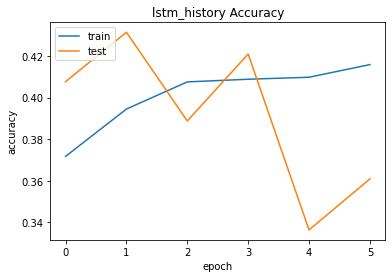

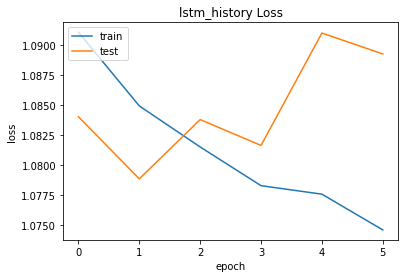

       loss  accuracy  val_loss  val_accuracy
0  1.091096  0.371685  1.084045      0.407673
1  1.084946  0.394491  1.078854      0.431458
2  1.081517  0.407559  1.083802      0.388747
3  1.078287  0.408840  1.081648      0.420972
4  1.077577  0.409801  1.091028      0.336317
5  1.074593  0.415887  1.089284      0.360870


In [29]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize lstm_history for accuracy
plt.plot(simple_lstm_history.history['accuracy'])
plt.plot(simple_lstm_history.history['val_accuracy'])
plt.title('lstm_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize lstm_history for loss
plt.plot(simple_lstm_history.history['loss'])
plt.plot(simple_lstm_history.history['val_loss'])
plt.title('lstm_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(simple_lstm_history.history)
print(history_pd)


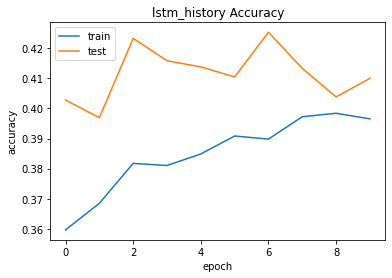

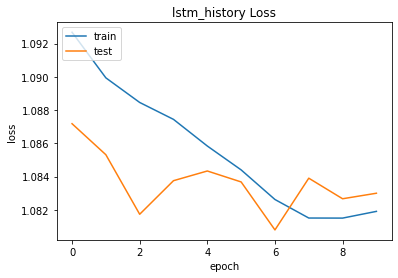

       loss  accuracy  val_loss  val_accuracy
0  1.092677  0.359641  1.087179      0.402813
1  1.089936  0.368482  1.085314      0.396931
2  1.088456  0.381742  1.081735      0.423274
3  1.087439  0.381038  1.083754      0.415857
4  1.085837  0.384881  1.084336      0.413811
5  1.084402  0.390839  1.083678      0.410486
6  1.082623  0.389814  1.080794      0.425320
7  1.081508  0.397245  1.083904      0.413299
8  1.081504  0.398398  1.082667      0.403836
9  1.081908  0.396541  1.082999      0.409974


In [30]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize lstm_history for accuracy
plt.plot(complex_lstm_history.history['accuracy'])
plt.plot(complex_lstm_history.history['val_accuracy'])
plt.title('lstm_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize lstm_history for loss
plt.plot(complex_lstm_history.history['loss'])
plt.plot(complex_lstm_history.history['val_loss'])
plt.title('lstm_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(complex_lstm_history.history)
print(history_pd)
